# Description
Notebook to run simulations for Referee comment 4.2, on using the Meteoric Seed Set instead of our seed set during expansion and sampling redox

### Load packages

In [1]:
import networkExpansionPy.lib as ne
import numpy as np
import pandas as pd
import pickle as pickle
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr,pearsonr,mannwhitneyu
from statsmodels.stats.multitest import multipletests
plt.rcParams['font.family'] = 'Arial'

import warnings
from scipy.sparse import (spdiags, SparseEfficiencyWarning, csc_matrix,
    csr_matrix, isspmatrix, dok_matrix, lil_matrix, bsr_matrix)
warnings.simplefilter('ignore',SparseEfficiencyWarning)

def load_data(network_name):
    with open(ne.asset_path  + "/metabolic_networks/" + network_name,"rb") as filehandler:
        metabolism = pickle.load(filehandler)
    return metabolism

# load the metabolism object from the repo
#metabolism = load_data('metabolism.23Aug2022.pkl')
#model_id = "metabolism.v4.20Mar2023.pkl"
model_id = "metabolism.v8.01May2023.pkl"
metabolism = pd.read_pickle('/Users/joshuagoldford/Documents/github/network-expansion-assets/models/' + model_id)
cids = metabolism.coenzymes

In [2]:
seed = pd.read_csv('../assets/seed_set.csv')
background = seed[seed["Type"].isin(["Background"])].ID.tolist()
cpd_base = seed[~seed["Type"].isin(['Sulfur source',"Nitrogen source"])].ID.tolist()

In [28]:
df = pd.read_csv("data/randomSeeds.1e5.csv",index_col=0)

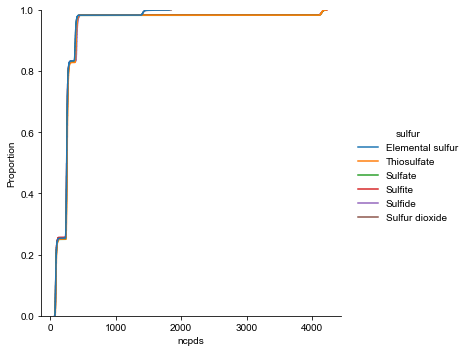

In [53]:
sns.displot(x="ncpds",data=df,kind="ecdf",hue="sulfur")

In [60]:
dfa = df[(df.nitrogen == "Ammonia") & (df.sulfur == "Sulfide")]
dfa["large"] = dfa.ncpds > 1e3

In [74]:
dfa  = df[(df.nitrogen == "Ammonia")]

In [81]:
dfa[dfa.sulfur == "Sulfate"].max()

nitrogen    Ammonia
sulfur      Sulfate
mean DOR    2.56803
ncpds          4203
dtype: object

<AxesSubplot:xlabel='mean DOR', ylabel='ncpds'>

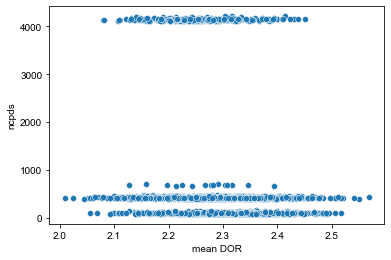

In [67]:

sns.scatterplot(x="mean DOR",y="ncpds",data=dfa)

<AxesSubplot:xlabel='large', ylabel='mean DOR'>

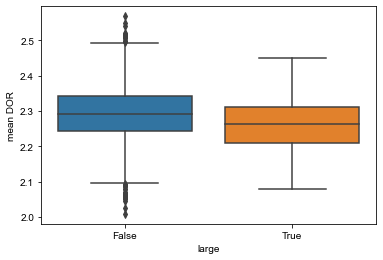

In [72]:
sns.boxplot(x="large",y="mean DOR",data=dfa)

In [41]:
x_order = df.groupby("nitrogen").mean().sort_values("ncpds",ascending=False).index.tolist()

In [46]:
df.set_index("nitrogen").loc[x_order].reset_index()

,nitrogen,sulfur,mean DOR,ncpds
0,Ammonia,Thiosulfate,2.466903,388
1,Ammonia,Sulfate,2.148893,87
2,Ammonia,Sulfite,2.262217,398
3,Ammonia,Sulfite,2.300786,383
4,Ammonia,Sulfur dioxide,2.172564,122
...,...,...,...,...
99995,Hydroxylamine,Elemental sulfur,2.336274,94
99996,Hydroxylamine,Sulfite,2.179522,264
99997,Hydroxylamine,Sulfide,2.211967,90
99998,Hydroxylamine,Sulfate,2.278006,261


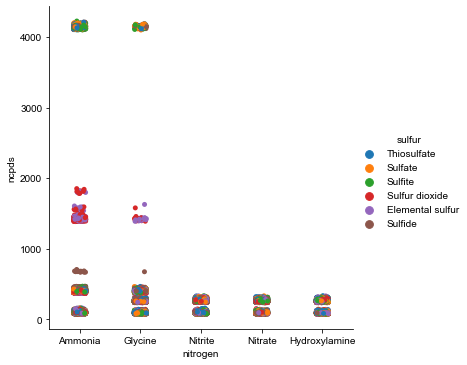

In [47]:
sns.catplot(x="nitrogen",data=df.set_index("nitrogen").loc[x_order].reset_index(),y="ncpds",hue="sulfur")


In [51]:
df[df.sulfur == "Sulfate"].sort_values("ncpds")

,nitrogen,sulfur,mean DOR,ncpds
49407,Hydroxylamine,Sulfate,2.205138,75
17135,Glycine,Sulfate,2.453210,75
91717,Nitrate,Sulfate,2.356228,75
94172,Hydroxylamine,Sulfate,2.320952,75
2487,Nitrate,Sulfate,2.280850,76
...,...,...,...,...
48709,Ammonia,Sulfate,2.244167,4193
22318,Ammonia,Sulfate,2.385161,4194
30324,Ammonia,Sulfate,2.263292,4199
94831,Ammonia,Sulfate,2.375613,4200


In [22]:
dff = df[df.nitrogen == "Nitrate"]

In [27]:
#dff.sort_values("ncpds")
#"a" in ["a","b"]

In [71]:


# create dictionary with cid mappings

nitrogen_sources = {
    "Ammonia": "C00014",
    "Nitrate": "C00244",
    "Nitrite": "C00088",
    "Glycine": "C00037",
    "Hydroxylamine": "C00192"}
    
sulfur_sources = {  
    "Sulfide": "C00283",
    "Sulfite": "C00094",
    "Sulfate": "C00059",
    "Thiosulfate": "C00320",
    "Sulfur dioxide":"C09306",
    "Elemental sulfur": "C00087"
}

# create dictionary with oxidation states
nitrogen_sources_oxidation_states = {
    "Ammonia": -3,        # C00014
    "Nitrate": 5,         # C00244
    "Nitrite": 3,         # C00088
    "Hydroxylamine": 1,   # C00192
    "Glycine": -2
}

sulfur_sources_oxidation_states = {
    "Sulfide": -2,              # C00283
    "Sulfite": 4,               # C00094
    "Sulfate": 6,               # C00059
    "Thiosulfate": [2, 6],      # C00320
    "Sulfur dioxide": 4,        # C09306
    "Elemental sulfur": 0,      # C00087
}


### Run network expansion -- different N and S sources

In [72]:
results = {"nitrogen":[],"sulfur":[],"network_size":[],"ne_cpds":[]}
for n in list(nitrogen_sources):
    for s in list(sulfur_sources):
        seed_set = cpd_base + [sulfur_sources[s],nitrogen_sources[n]]
        ne_cpds,ne_rxns = metabolism.expand(seed_set,algorithm='trace')
        results["nitrogen"].append(n)
        results["sulfur"].append(s)
        results["network_size"].append(len(ne_cpds))
        results["ne_cpds"].append(ne_cpds)

results = pd.DataFrame(results)

In [73]:
# sort by oxidation state of the sulfur or nitrogen source
sorder = pd.Series({x:np.min(y) for x,y in sulfur_sources_oxidation_states.items()}).sort_values().index.tolist()
norder = pd.Series({x:np.min(y) for x,y in nitrogen_sources_oxidation_states.items()}).sort_values().index.tolist()

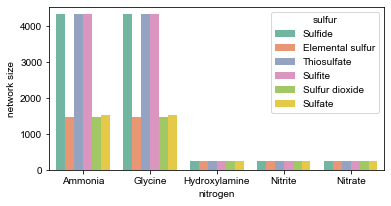

In [103]:
plt.figure(figsize=(6, 3))  
sns.barplot(x="nitrogen",y="network_size",hue="sulfur",data=results,palette="Set2",hue_order=sorder,order=norder)
plt.ylabel("network size")
plt.savefig("figs/nitrogen_vs_sulfur_sources.svg")

In [84]:
# (ii) randomize the seed set to control for state of reduction in organic compounds  
seed = pd.read_csv('../assets/seed_set.csv')
cpd_base = seed[~seed["Type"].isin(["Organic carbon"])].ID.tolist()

In [86]:
carbon = seed[seed["Type"].isin(["Organic carbon"])].ID.tolist()

In [82]:
dor = pd.read_csv("../assets/keggCHOmolecules.reductionState.csv")


In [110]:
import re
def get_c_num(formula):
    match = re.search('C(\d+)', formula)
    if match:
        return  match.group(1)
    else:
        return None
    
dor["c"]= dor.formula.apply(lambda x: get_c_num(x))
dor = dor[~dor.c.apply(lambda x: x is None)]
dor["c"] = dor.c.apply(int)

/Users/joshuagoldford/opt/miniconda3/envs/ne.py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [123]:
dor[dor.c < dor[dor.cid.isin(carbon)].c.max() + 1]

,Unnamed: 0,cid,formula,name,num_rgroup,electrons,reduction,water_amt,water_per_c,c
0,21,C00022,C3H4O3,Pyruvate; Pyruvic acid; 2-Oxopropanoate; 2-Oxo...,0,46.0,1.666667,3.0,1.000000,3
1,25,C00026,C5H6O5,2-Oxoglutarate; Oxoglutaric acid; 2-Ketoglutar...,0,76.0,1.600000,5.0,1.000000,5
2,30,C00031,C6H12O6,D-Glucose; Grape sugar; Dextrose; Glucose; D-G...,0,96.0,2.000000,6.0,1.000000,6
3,32,C00033,C2H4O2,Acetate; Acetic acid; Ethanoic acid,0,32.0,2.000000,2.0,1.000000,2
4,35,C00036,C4H4O5,Oxaloacetate; Oxalacetic acid; Oxaloacetic aci...,0,68.0,1.250000,3.0,0.750000,4
...,...,...,...,...,...,...,...,...,...,...
5977,17371,C20899,C6H4O3,"Furan-2,5-dicarbaldehyde; 2,5-Furandicarboxald...",0,NaN,1.833333,9.0,1.500000,6
5978,17372,C20900,C6H6O4,5-(Dihydroxymethyl)furan-2-carbaldehyde,0,NaN,1.833333,8.0,1.333333,6
5979,17373,C20901,C6H6O5,5-(Dihydroxymethyl)furan-2-carboxylate,0,NaN,1.666667,7.0,1.166667,6
5980,17374,C20902,C6H10O5,"3,6-Anhydro-alpha-L-galactopyranose",0,NaN,2.000000,7.0,1.166667,6


In [124]:
546 * 0.25 

136.5

### Run network expansion with many samples of CHO molecules at different DORs

In [78]:
seeds = pd.read_csv('../assets/seed_set.csv')
dor = pd.read_csv("../assets/keggCHOmolecules.reductionState.csv")
seed_set_base = seeds[~seeds.Type.isin(["Organic carbon"])].ID.tolist()
dg = dor.sort_values("reduction")

r_upper = dg.reduction.quantile(q=0.75)
r_lower = dg.reduction.quantile(q=0.25)

samples = 100
N = 21
simulations = {"mean_dor":[],"ne_size":[],"dtype":[]}

for i in range(samples):
    c_lower = dg[dg.reduction < r_lower].sample(N).cid.tolist()
    s = c_lower + seed_set_base
    nec,ner = metabolism.expand(s,algorithm='naive')
    r = dg[dg.cid.isin(c_lower)].reduction.mean()
    simulations["mean_dor"].append(r)
    simulations["ne_size"].append(len(nec))
    simulations["dtype"].append("lower")

    
for i in range(samples):
    c_upper = dg[dg.reduction > r_upper].sample(N).cid.tolist()
    s = c_upper + seed_set_base
    nec,ner = metabolism.expand(s,algorithm='naive')
    r = dg[dg.cid.isin(c_upper)].reduction.mean()
    simulations["mean_dor"].append(r)
    simulations["ne_size"].append(len(nec))
    simulations["dtype"].append("higher")
    
simulations = pd.DataFrame(simulations)


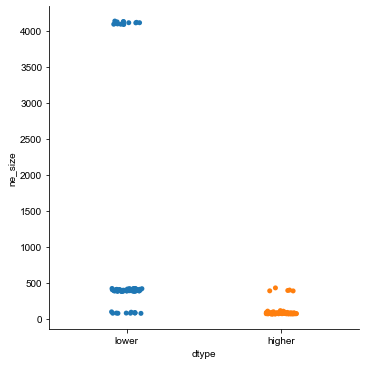

In [84]:
sns.catplot(x="dtype",y="ne_size",data=r)

In [88]:
len(r[r["ne_size"] > 4e3])

15

In [91]:
# run 1e3 simulations
seeds = pd.read_csv('../assets/seed_set.csv')
dor = pd.read_csv("../assets/keggCHOmolecules.reductionState.csv")
seed_set_base = seeds[~seeds.Type.isin(["Organic carbon"])].ID.tolist()
dg = dor.sort_values("reduction")

r_upper = dg.reduction.quantile(q=0.75)
r_lower = dg.reduction.quantile(q=0.25)

samples = 1000
N = 21
simulations = {"mean_dor":[],"ne_size":[],"dtype":[]}

for i in range(samples):
    c_lower = dg[dg.reduction < r_lower].sample(N).cid.tolist()
    s = c_lower + seed_set_base
    nec,ner = metabolism.expand(s,algorithm='naive')
    r = dg[dg.cid.isin(c_lower)].reduction.mean()
    simulations["mean_dor"].append(r)
    simulations["ne_size"].append(len(nec))
    simulations["dtype"].append("lower")

    
for i in range(samples):
    c_upper = dg[dg.reduction > r_upper].sample(N).cid.tolist()
    s = c_upper + seed_set_base
    nec,ner = metabolism.expand(s,algorithm='naive')
    r = dg[dg.cid.isin(c_upper)].reduction.mean()
    simulations["mean_dor"].append(r)
    simulations["ne_size"].append(len(nec))
    simulations["dtype"].append("higher")
    
simulations = pd.DataFrame(simulations)

Text(-1.4499999999999957, 0.5, 'network size (# compounds)')

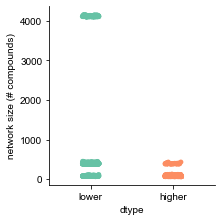

In [105]:
#simulations
sns.catplot(x="dtype",y="ne_size",data=simulations,palette='Set2',height=3)
plt.ylabel("network size (# compounds)")
plt.ylabel("CHO redox class")


In [94]:
simulations.to_csv("redox_cho_random_sample.16Apr2023.csv")

In [108]:
lmap = {"lower":"low DOR","higher":"high DOR"}
simulations["population"] = simulations["dtype"].apply(lambda x: lmap[x])

Text(0.5, 6.800000000000008, '')

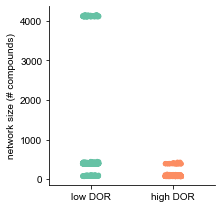

In [111]:
#simulations
sns.catplot(x="population",y="ne_size",data=simulations,palette='Set2',height=3)
plt.ylabel("network size (# compounds)")
plt.xlabel("")
